# Imports and data processing


In [ ]:
!pip install pretty_midi

     |████████████████████████████████| 5.6MB 6.9MB/s 
     |████████████████████████████████| 61kB 9.7MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-cp37-none-any.whl size=5591954 sha256=0ee3382aa281186c522d771aac5dceb1e5b84a64f55d9e538bb5c8bbec257729
  Stored in directory: /root/.cache/pip/wheels/4c/a1/c6/b5697841db1112c6e5866d75a6b6bf1bef73b874782556ba66
Successfully built pretty-midi


In [ ]:
import random
import os
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset

import random as rd

import copy

# we use GPU if available, otherwise CPU
device_to_use = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_to_use)
print(f"Using {device_to_use} device")


Using cuda:0 device


In [ ]:
!unzip classical3D.zip

In [ ]:
def get_samples(style="J", length=64, n=1000, random=False):
    """Return the preprocessed samples

    Parameters
    ----------
    style : str, optional
        Style of the music, one of {"J", "C"} (for "Jazz" and "Classic"), by default "J"
    length : int, optional
        The length in time steps of each samples
    n : int, optional
        Number of samples which will be returned, by default 100
    random : bool, optional
        Whether to randomize the samples or not, by default False

    Returns
    -------
    List (of Numpy arrays)
        List of samples
    """

    folder = ""
    if style == "J":
      folder = "content/jazz3D"
    
    elif style == "C":
      folder = "content/classical3D"

    else:
      raise Exception("'style' must be one of {'J', 'C'}")
   
      
    list_filenames = os.listdir(folder)
    nb_samples_per_file = max(int(n/len(list_filenames)), 1)

    samples = []
    for filename in list_filenames:
      if filename[-3:] =="npy":
         
          
        filepath = folder + "/" + filename
        

        all_file = np.load(filepath).astype(int)
        all_file_size = len(all_file)

        for k in range(nb_samples_per_file):
          first_index = rd.randint(0, all_file_size-length-1)
          sample = all_file[first_index:first_index+length]
          sample_one_d = np.zeros((64, 84))
          for i in range(64):
            for j in range(84):
              if sample[i, j, 0] == 1:  # note is hit
                sample_one_d[i, j] = 1
              elif sample[i, j, 1] == 1:  # note is sustained
                sample_one_d[i, j] = 0
              else:  # no note played
                sample_one_d[i, j] = -1
          samples.append(sample_one_d.reshape((1, 64 , 84)))
    return np.vstack(samples)

# Model creation

In [ ]:
latent_dim = 100

class CNNGenerator(nn.Module):
    def __init__(self, deepth):
        super(CNNGenerator, self).__init__()
        n_features = latent_dim
        n_out = 64 * 84
   
        # Latent vector going into a convolution
        self.convt1 =  nn.ConvTranspose2d(latent_dim, deepth*8, 4, 1, 0, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(deepth*8)

        # state size : (deepth*8, 4, 4)
        self.convt2 = nn.ConvTranspose2d(deepth*8, deepth*4, 4, 2, 1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(deepth*4)

        #state size : (deepth*4, 8, 8)
        self.convt3 = nn.ConvTranspose2d(deepth*4, deepth*2, (4,2),(2,3), 1,bias=False)
        self.batchnorm3 = nn.BatchNorm2d(deepth*2)

        #state size : (deepth*2, 16, 21)
        self.convt4 = nn.ConvTranspose2d(deepth*2, deepth, 4,2, 1,bias=False)
        self.batchnorm4 = nn.BatchNorm2d(deepth)

        #state size : (deepth, 32, 42)
        self.convt5 = nn.ConvTranspose2d(deepth,1, 4,2, 1,bias=False)

    def forward(self, x):
        x = self.convt1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = self.convt2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = self.convt3(x)
        x = self.batchnorm3(x)
        x = F.relu(x)
        x = self.convt4(x)
        x = self.batchnorm4(x)
        x = F.relu(x)
        x = self.convt5(x)
        x = F.tanh(x)
        x = x.view(x.size()[0],64,84)
        return x

In [ ]:
class CNNDiscriminator(nn.Module):
    def __init__(self, num_conv1, kernel_size1, num_conv2, kernel_size2, num_fc):
        super(CNNDiscriminator, self).__init__()
        n_features = 64 * 84
        n_out = 1

        self.conv_1 = nn.Conv2d(in_channels=1,out_channels=num_conv1,kernel_size=kernel_size1)
        self.drop1 = nn.Dropout(0.3)
        self.conv_2 = nn.Conv2d(num_conv1,num_conv2,kernel_size1)
        self.drop2 = nn.Dropout(0.3)
        self.fc_1 = nn.Linear(1680, num_fc)
        self.fc_2 = nn.Linear(num_fc, n_out)
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.drop1(x)
        # print("after conv")
        # print(x.size())
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        # print("aftermaxpool")
        # print(x.size())
        x = self.conv_2(x)
        x = self.drop2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size()[0],x.size()[1]*x.size()[2]*x.size()[3])
        x = F.relu(self.fc_1(x))
        # x = self.mbd1(x)
        x = F.sigmoid(self.fc_2(x))
        return x

    def load(self, backup):
        for m_from, m_to in zip(backup.modules(), self.modules()):
             if isinstance(m_to, nn.Linear) or isinstance(m_to, nn.Conv2d):
                m_to.weight.data = m_from.weight.data.clone()
                if m_to.bias is not None:
                    m_to.bias.data = m_from.bias.data.clone()

In [ ]:
def get_dist_matrix(numpy_array_data):
  dist = 0
  counter = 0
  for i in range(len(numpy_array_data)):
    matrix_i = numpy_array_data[i]
    for j in range(i+1, len(numpy_array_data)):
      matrix_j = numpy_array_data[j]
      counter+=1

      dist += np.abs(matrix_i-matrix_j).sum()
  
  return dist/counter


# Training


In [ ]:
n = 3000
batch_size = 16
data = get_samples(style="C", n=n, random=True)
dataset = TensorDataset(torch.Tensor(data).type(torch.float), torch.Tensor(np.ones((data.shape[0], 1))).type(torch.int64))
loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=batch_size)

In [ ]:
n_epochs = 500

G = CNNGenerator(16).to(device)

num_conv1 = 10
num_conv2 = 20
kernel_size1 = 12
kernel_size2 = 12
num_fc = 16*84
D = CNNDiscriminator(num_conv1, kernel_size1, num_conv2, kernel_size2, num_fc).to(device)

loss = nn.BCELoss()
d_optimizer = optim.SGD(D.parameters(), lr=1e-3, momentum=0.5)
g_optimizer = optim.SGD(G.parameters(), lr=1e-3, momentum=0.5)

In [ ]:
nb_landmark_seeds = 10

landmark_seeds = Variable(torch.FloatTensor(torch.randn(nb_landmark_seeds, latent_dim))).view(nb_landmark_seeds,latent_dim, 1,1 )


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 0: D (0.1331 real_err, 0.6580 fake_err) G (1.3933 err) 
Generated data: 
Min value: -0.9991403222084045 / Max value: 0.7088823318481445
Note played simultaneously for generated data  mean/var: -59.87 / 6.27


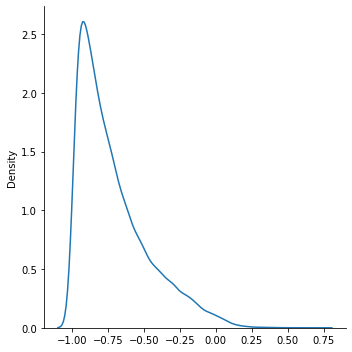

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 920.4977918836805
Epoch 5: D (0.2093 real_err, 0.5221 fake_err) G (1.6093 err) 
Generated data: 
Min value: -0.9999999403953552 / Max value: 0.9976509213447571
Note played simultaneously for generated data  mean/var: -70.37 / 0.53
Epoch 10: D (0.4392 real_err, 0.6640 fake_err) G (1.1123 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999774694442749
Note played simultaneously for generated data  mean/var: -72.81 / 0.87


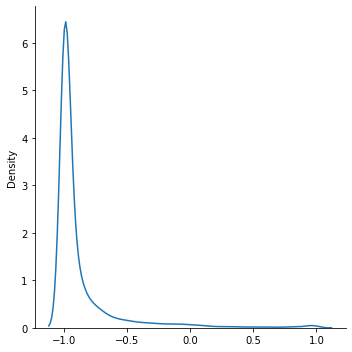

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 621.1443488226996
Epoch 15: D (0.3536 real_err, 0.5373 fake_err) G (1.6391 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999063611030579
Note played simultaneously for generated data  mean/var: -75.28 / 0.10
Epoch 20: D (0.9156 real_err, 0.2309 fake_err) G (1.8596 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999619126319885
Note played simultaneously for generated data  mean/var: -76.31 / 4.17


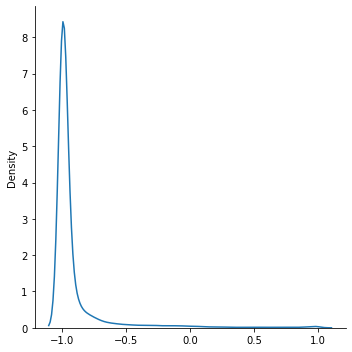

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 605.4295945909288
Epoch 25: D (0.0825 real_err, 1.9997 fake_err) G (0.8007 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999566078186035
Note played simultaneously for generated data  mean/var: -75.75 / 2.99
Epoch 30: D (1.1674 real_err, 0.0988 fake_err) G (1.7575 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999786615371704
Note played simultaneously for generated data  mean/var: -76.37 / 3.27


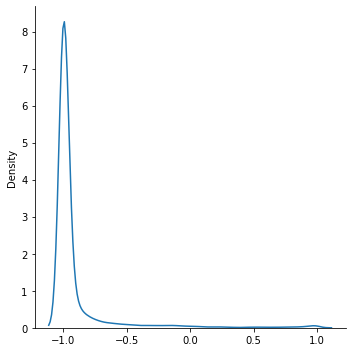

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 588.0534152560764
Epoch 35: D (0.4002 real_err, 0.2782 fake_err) G (1.4494 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999989867210388
Note played simultaneously for generated data  mean/var: -77.19 / 1.91
Epoch 40: D (0.3114 real_err, 0.2073 fake_err) G (3.4658 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999998807907104
Note played simultaneously for generated data  mean/var: -76.60 / 1.70


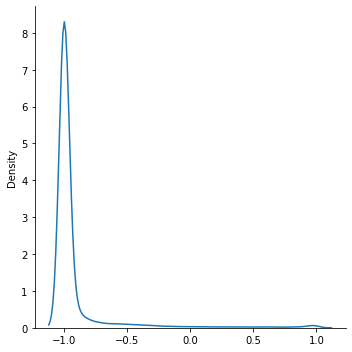

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 585.346875
Epoch 45: D (0.0856 real_err, 2.7686 fake_err) G (2.6932 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999783039093018
Note played simultaneously for generated data  mean/var: -77.55 / 1.52
Epoch 50: D (0.7265 real_err, 0.0566 fake_err) G (2.4965 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -77.48 / 4.62


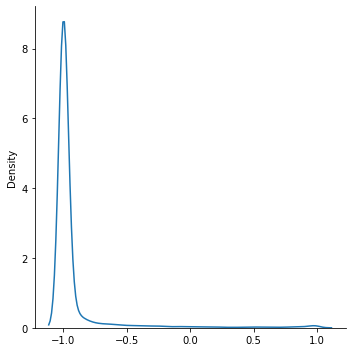

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 603.7826266818577
Epoch 55: D (0.1878 real_err, 0.5282 fake_err) G (3.1565 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999998211860657
Note played simultaneously for generated data  mean/var: -77.37 / 0.49
Epoch 60: D (0.7920 real_err, 0.0804 fake_err) G (2.3031 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999966621398926
Note played simultaneously for generated data  mean/var: -77.87 / 5.64


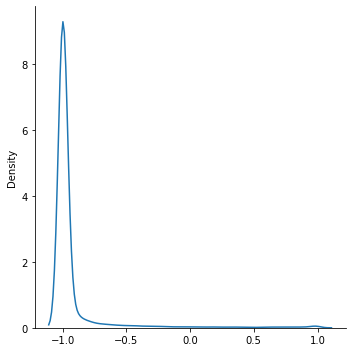

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 517.9349582248263
Epoch 65: D (0.1551 real_err, 0.2895 fake_err) G (4.5111 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999978542327881
Note played simultaneously for generated data  mean/var: -79.29 / 0.98
Epoch 70: D (0.2030 real_err, 0.2696 fake_err) G (2.6429 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999971985816956
Note played simultaneously for generated data  mean/var: -77.99 / 0.97


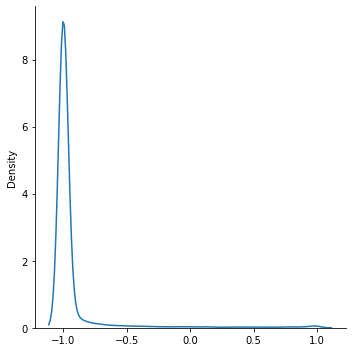

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 535.4173733181424
Epoch 75: D (0.3326 real_err, 0.0973 fake_err) G (1.3983 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999749064445496
Note played simultaneously for generated data  mean/var: -77.41 / 1.81
Epoch 80: D (1.8048 real_err, 0.0975 fake_err) G (1.5977 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999967217445374
Note played simultaneously for generated data  mean/var: -78.03 / 0.51


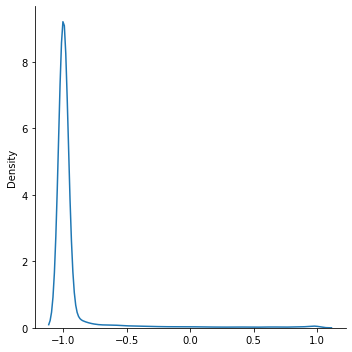

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 554.0568623860677
Epoch 85: D (0.0128 real_err, 0.6578 fake_err) G (4.2946 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999997019767761
Note played simultaneously for generated data  mean/var: -78.80 / 0.60
Epoch 90: D (0.7231 real_err, 0.1131 fake_err) G (3.4738 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999973177909851
Note played simultaneously for generated data  mean/var: -78.83 / 1.08


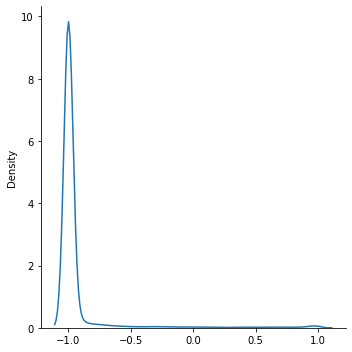

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 546.9406911214193
Epoch 95: D (0.7870 real_err, 0.1174 fake_err) G (3.9024 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999993443489075
Note played simultaneously for generated data  mean/var: -78.47 / 0.46
Epoch 100: D (0.6055 real_err, 0.0763 fake_err) G (2.6746 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999990463256836
Note played simultaneously for generated data  mean/var: -77.68 / 1.63


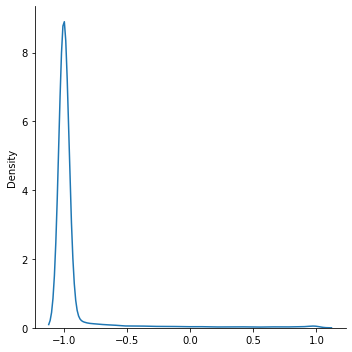

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 469.2877336290148
Epoch 105: D (0.2862 real_err, 0.1671 fake_err) G (3.1950 err) 
Generated data: 
Min value: -1.0 / Max value: 0.999999463558197
Note played simultaneously for generated data  mean/var: -78.85 / 2.29
Epoch 110: D (0.0522 real_err, 0.2245 fake_err) G (3.0556 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999999403953552
Note played simultaneously for generated data  mean/var: -78.83 / 5.27


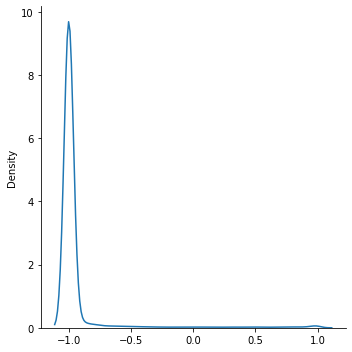

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 545.1095818413628
Epoch 115: D (0.0745 real_err, 0.5560 fake_err) G (4.2516 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999989867210388
Note played simultaneously for generated data  mean/var: -78.98 / 6.43
Epoch 120: D (0.0444 real_err, 0.3291 fake_err) G (1.8051 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999996423721313
Note played simultaneously for generated data  mean/var: -77.74 / 2.97


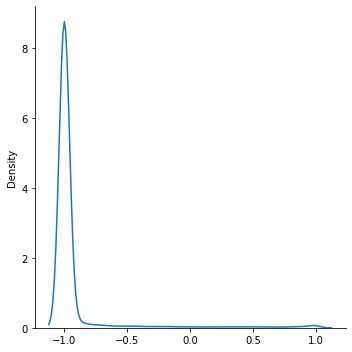

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 530.1619340684679
Epoch 125: D (0.1014 real_err, 0.3542 fake_err) G (2.3732 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999999403953552
Note played simultaneously for generated data  mean/var: -78.66 / 6.20
Epoch 130: D (0.0306 real_err, 0.0100 fake_err) G (2.3959 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -79.37 / 4.11


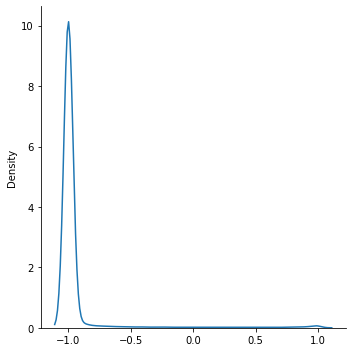

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 526.4108005099827
Epoch 135: D (0.0078 real_err, 1.3498 fake_err) G (3.3189 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -79.44 / 6.83
Epoch 140: D (0.3782 real_err, 0.3690 fake_err) G (1.7426 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999991059303284
Note played simultaneously for generated data  mean/var: -79.03 / 7.83


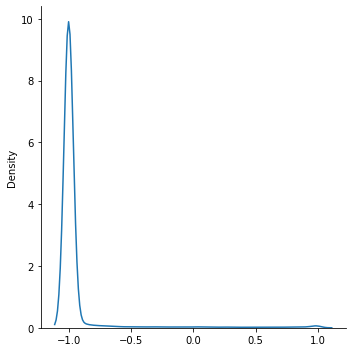

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 465.86432054307727
Epoch 145: D (0.2407 real_err, 0.0096 fake_err) G (1.9542 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -78.04 / 1.68
Epoch 150: D (0.1667 real_err, 0.0507 fake_err) G (1.4915 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999999403953552
Note played simultaneously for generated data  mean/var: -79.30 / 5.31


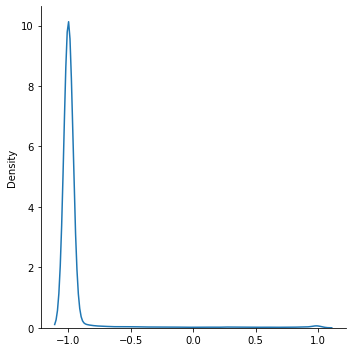

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 450.81995069715714
Epoch 155: D (0.1960 real_err, 0.0922 fake_err) G (4.2694 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -79.12 / 7.81
Epoch 160: D (0.2517 real_err, 0.9714 fake_err) G (1.5052 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -79.81 / 0.47


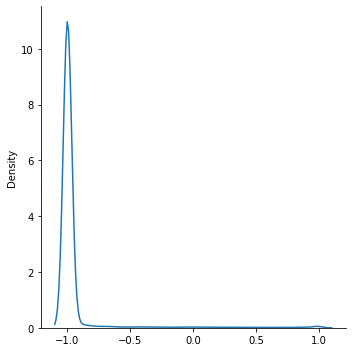

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 443.8765411376953
Epoch 165: D (0.2483 real_err, 0.0752 fake_err) G (2.4588 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999999403953552
Note played simultaneously for generated data  mean/var: -79.93 / 2.93
Epoch 170: D (0.1993 real_err, 0.0236 fake_err) G (2.6824 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -79.41 / 5.50


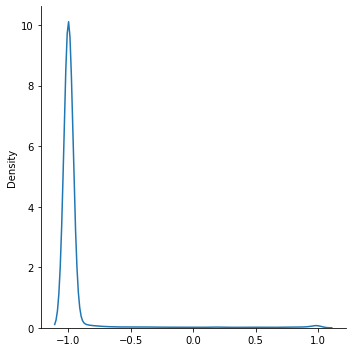

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 455.69506106906465
Epoch 175: D (0.6155 real_err, 0.0678 fake_err) G (3.6945 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -79.76 / 4.11
Epoch 180: D (0.0014 real_err, 0.0322 fake_err) G (3.5653 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -80.09 / 3.63


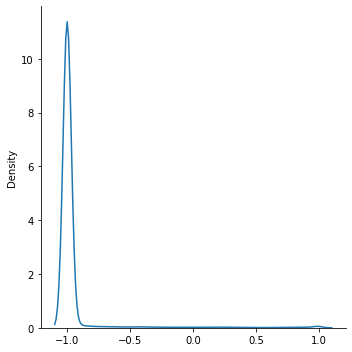

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 412.75105743408204
Epoch 185: D (0.0611 real_err, 0.1238 fake_err) G (3.3434 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999999403953552
Note played simultaneously for generated data  mean/var: -79.88 / 4.39
Epoch 190: D (0.5087 real_err, 0.0481 fake_err) G (3.7653 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -79.35 / 0.52


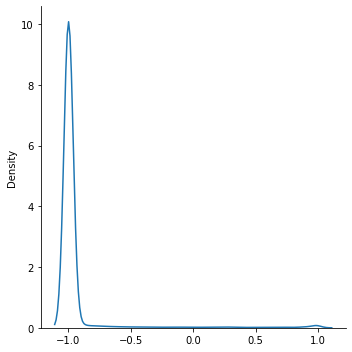

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 395.04593844943577
Epoch 195: D (0.0066 real_err, 0.0090 fake_err) G (6.6022 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999905228614807
Note played simultaneously for generated data  mean/var: -79.51 / 4.08
Epoch 200: D (0.1610 real_err, 0.0598 fake_err) G (4.3188 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -80.06 / 4.50


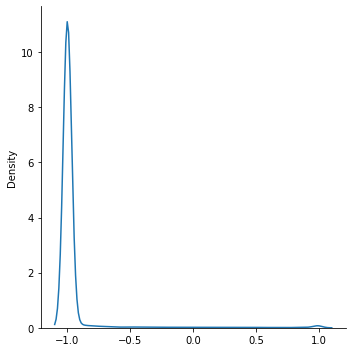

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 376.7368188646105
Epoch 205: D (0.7258 real_err, 0.0286 fake_err) G (4.1469 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -79.21 / 8.97
Epoch 210: D (0.0134 real_err, 0.0148 fake_err) G (2.1738 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -79.92 / 8.76


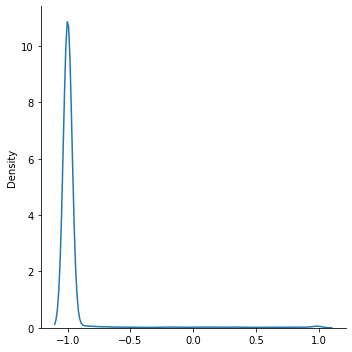

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 404.60009485880533
Epoch 215: D (0.0500 real_err, 0.1241 fake_err) G (4.0475 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -79.59 / 4.72
Epoch 220: D (0.0077 real_err, 0.0093 fake_err) G (3.3902 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -80.49 / 6.20


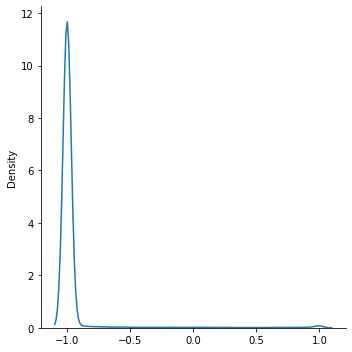

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 414.4052057054308
Epoch 225: D (0.0006 real_err, 0.0466 fake_err) G (4.4477 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -80.26 / 4.35
Epoch 230: D (0.0005 real_err, 0.3816 fake_err) G (2.9244 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -79.98 / 6.59


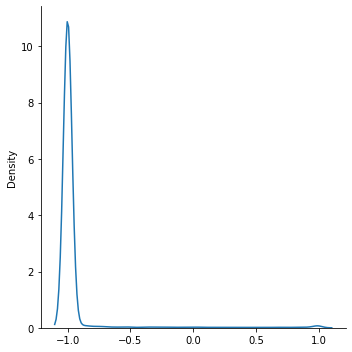

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 403.328271399604
Epoch 235: D (0.4990 real_err, 0.2714 fake_err) G (2.8458 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -80.29 / 10.20
Epoch 240: D (0.0085 real_err, 0.0183 fake_err) G (5.3583 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -80.51 / 7.79


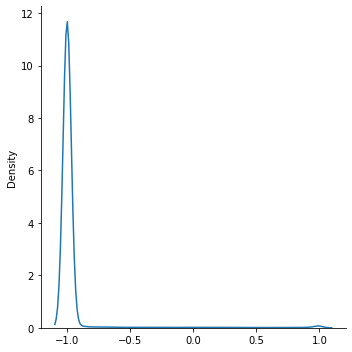

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 310.8488470077515
Epoch 245: D (0.7299 real_err, 0.6872 fake_err) G (4.1412 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -80.86 / 9.30
Epoch 250: D (0.0024 real_err, 0.0321 fake_err) G (5.4706 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -81.31 / 6.19


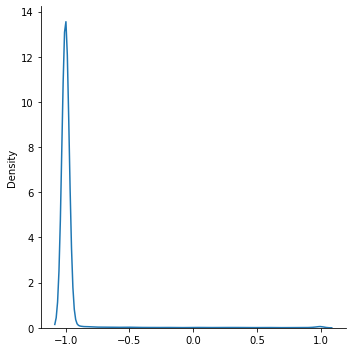

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 261.49308420817056
Epoch 255: D (0.0250 real_err, 0.0747 fake_err) G (4.8108 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -81.22 / 1.38
Epoch 260: D (0.0068 real_err, 0.2700 fake_err) G (4.7780 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -81.10 / 7.20


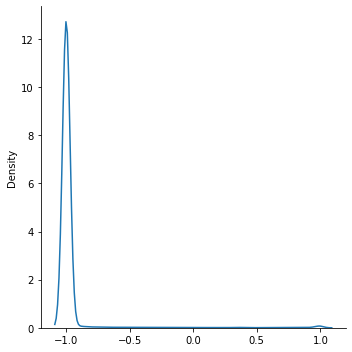

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 274.6161332448324
Epoch 265: D (0.0539 real_err, 0.0111 fake_err) G (6.8828 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -81.16 / 2.73
Epoch 270: D (0.0017 real_err, 0.0405 fake_err) G (5.4399 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -81.07 / 3.91


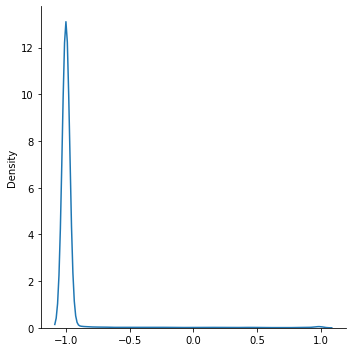

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 310.70644247266983
Epoch 275: D (0.0022 real_err, 0.0345 fake_err) G (3.6874 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -81.14 / 6.01
Epoch 280: D (0.0456 real_err, 0.0887 fake_err) G (6.5387 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -81.30 / 3.06


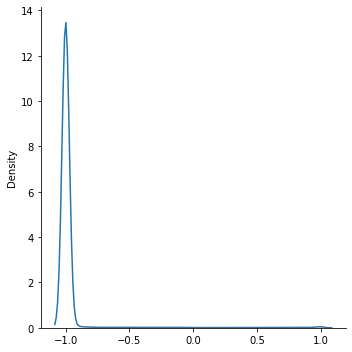

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 214.0455509185791
Epoch 285: D (0.0082 real_err, 0.0480 fake_err) G (3.1303 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -81.43 / 4.27
Epoch 290: D (0.0015 real_err, 0.0413 fake_err) G (5.8820 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -82.77 / 0.21


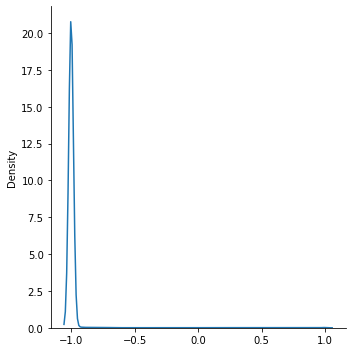

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 92.39037857055663
Epoch 295: D (0.0016 real_err, 0.1249 fake_err) G (6.5448 err) 
Generated data: 
Min value: -1.0 / Max value: 1.0
Note played simultaneously for generated data  mean/var: -82.54 / 5.53
Epoch 300: D (0.0021 real_err, 0.0278 fake_err) G (5.3418 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999999403953552
Note played simultaneously for generated data  mean/var: -82.63 / 3.08


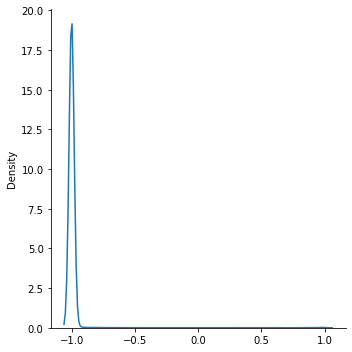

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 76.85754228697883
Epoch 305: D (0.0000 real_err, 0.0487 fake_err) G (6.1620 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999220371246338
Note played simultaneously for generated data  mean/var: -83.87 / 0.04
Epoch 310: D (0.0000 real_err, 0.0285 fake_err) G (6.0173 err) 
Generated data: 
Min value: -1.0 / Max value: 0.37648510932922363
Note played simultaneously for generated data  mean/var: -83.95 / 0.00


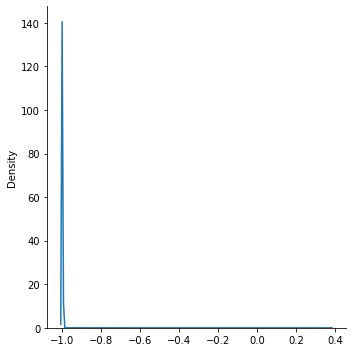

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 0.4301470544603136
Epoch 315: D (0.0000 real_err, 0.0206 fake_err) G (4.6478 err) 
Generated data: 
Min value: -1.0 / Max value: -0.9223335385322571
Note played simultaneously for generated data  mean/var: -84.00 / 0.00
Epoch 320: D (0.0000 real_err, 0.3904 fake_err) G (5.1465 err) 
Generated data: 
Min value: -1.0 / Max value: 0.0455220527946949
Note played simultaneously for generated data  mean/var: -83.98 / 0.00


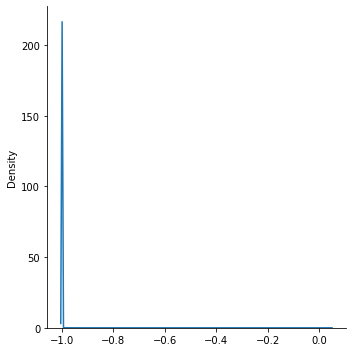

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 1.848328677813212
Epoch 325: D (0.0000 real_err, 0.0304 fake_err) G (4.3163 err) 
Generated data: 
Min value: -1.0 / Max value: 0.6315135955810547
Note played simultaneously for generated data  mean/var: -83.97 / 0.00
Epoch 330: D (0.9663 real_err, 0.0180 fake_err) G (1.7065 err) 
Generated data: 
Min value: -1.0 / Max value: -0.9203663468360901
Note played simultaneously for generated data  mean/var: -84.00 / 0.00


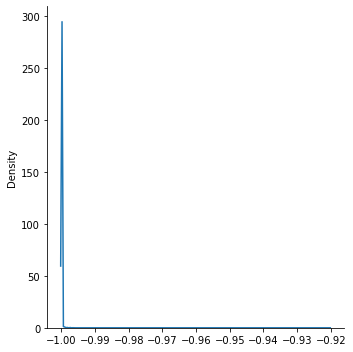

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 0.5113268428378634
Epoch 335: D (0.8939 real_err, 0.0277 fake_err) G (1.6667 err) 
Generated data: 
Min value: -1.0 / Max value: -0.42265626788139343
Note played simultaneously for generated data  mean/var: -83.99 / 0.00
Epoch 340: D (0.0000 real_err, 0.0472 fake_err) G (4.2047 err) 
Generated data: 
Min value: -1.0 / Max value: -0.801790177822113
Note played simultaneously for generated data  mean/var: -84.00 / 0.00


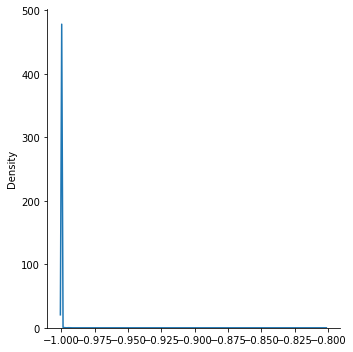

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 0.9195772886276246
Epoch 345: D (0.0000 real_err, 0.0370 fake_err) G (4.3722 err) 
Generated data: 
Min value: -1.0 / Max value: -0.9665217995643616
Note played simultaneously for generated data  mean/var: -84.00 / 0.00
Epoch 350: D (0.8670 real_err, 0.0338 fake_err) G (1.5597 err) 
Generated data: 
Min value: -1.0 / Max value: -0.9676578640937805
Note played simultaneously for generated data  mean/var: -84.00 / 0.00


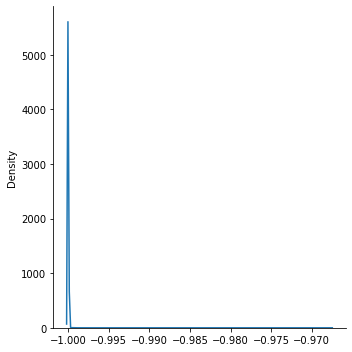

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 0.2841249254014757
Epoch 355: D (0.0000 real_err, 0.0197 fake_err) G (4.4689 err) 
Generated data: 
Min value: -1.0 / Max value: 0.07217211276292801
Note played simultaneously for generated data  mean/var: -83.99 / 0.00
Epoch 360: D (0.0000 real_err, 0.0192 fake_err) G (4.4963 err) 
Generated data: 
Min value: -1.0 / Max value: -0.9898204803466797
Note played simultaneously for generated data  mean/var: -84.00 / 0.00


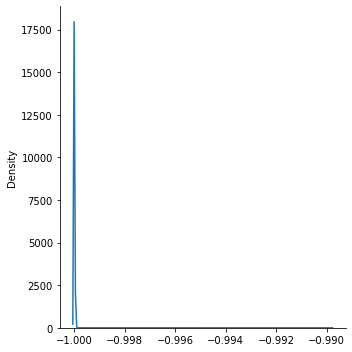

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 0.3687869177924262
Epoch 365: D (0.0000 real_err, 0.0188 fake_err) G (4.3715 err) 
Generated data: 
Min value: -1.0 / Max value: -0.8894540071487427
Note played simultaneously for generated data  mean/var: -84.00 / 0.00
Epoch 370: D (0.0000 real_err, 0.0331 fake_err) G (4.3766 err) 
Generated data: 
Min value: -1.0 / Max value: -0.9240406155586243
Note played simultaneously for generated data  mean/var: -84.00 / 0.00


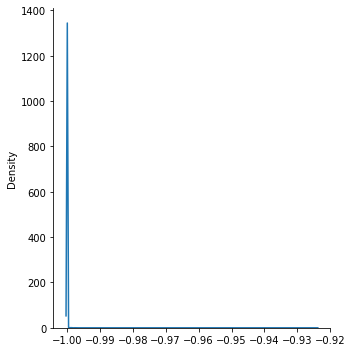

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 0.3464980946646796
Epoch 375: D (0.0000 real_err, 0.0253 fake_err) G (4.6186 err) 
Generated data: 
Min value: -1.0 / Max value: 0.8660850524902344
Note played simultaneously for generated data  mean/var: -83.97 / 0.00
Epoch 380: D (0.0000 real_err, 0.0222 fake_err) G (5.0739 err) 
Generated data: 
Min value: -1.0 / Max value: -0.9185121059417725
Note played simultaneously for generated data  mean/var: -84.00 / 0.00


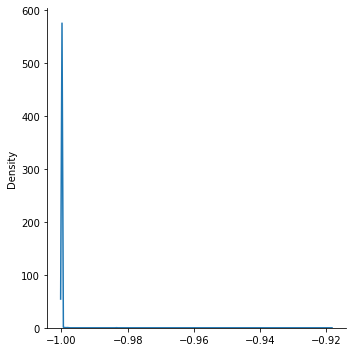

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 3.6899285448922052
Epoch 385: D (0.0000 real_err, 0.0358 fake_err) G (4.2691 err) 
Generated data: 
Min value: -1.0 / Max value: -0.9801567792892456
Note played simultaneously for generated data  mean/var: -84.00 / 0.00
Epoch 390: D (0.0000 real_err, 0.0262 fake_err) G (4.4215 err) 
Generated data: 
Min value: -1.0 / Max value: -0.5814424753189087
Note played simultaneously for generated data  mean/var: -84.00 / 0.00


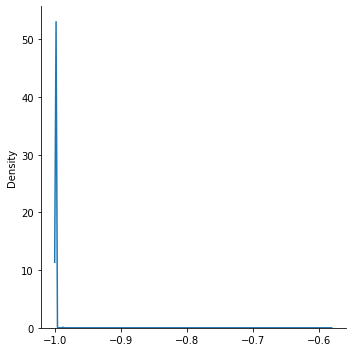

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 0.6144576840930515
Epoch 395: D (0.0000 real_err, 0.0295 fake_err) G (4.3442 err) 
Generated data: 
Min value: -1.0 / Max value: -0.9912128448486328
Note played simultaneously for generated data  mean/var: -84.00 / 0.00
Epoch 400: D (0.0000 real_err, 0.0320 fake_err) G (4.3547 err) 
Generated data: 
Min value: -1.0 / Max value: -0.8220939636230469
Note played simultaneously for generated data  mean/var: -84.00 / 0.00


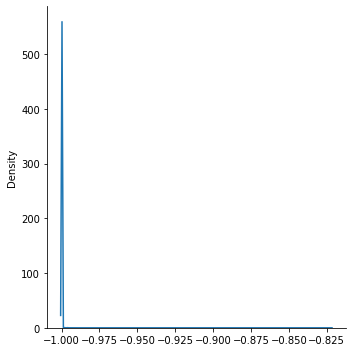

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 1.958095916112264
Epoch 405: D (0.0000 real_err, 0.0259 fake_err) G (4.6151 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9715314507484436
Note played simultaneously for generated data  mean/var: -83.95 / 0.01
Epoch 410: D (0.0000 real_err, 0.0282 fake_err) G (4.3687 err) 
Generated data: 
Min value: -1.0 / Max value: -0.9629285335540771
Note played simultaneously for generated data  mean/var: -84.00 / 0.00


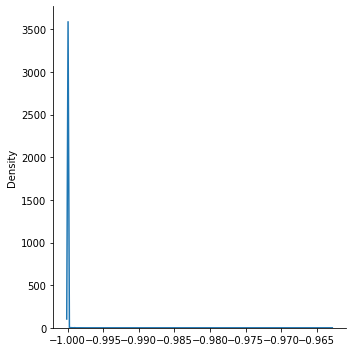

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 0.9663016637166341
Epoch 415: D (0.0000 real_err, 0.0230 fake_err) G (4.4679 err) 
Generated data: 
Min value: -1.0 / Max value: -0.986030638217926
Note played simultaneously for generated data  mean/var: -84.00 / 0.00
Epoch 420: D (0.0000 real_err, 0.0190 fake_err) G (4.6282 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9222221374511719
Note played simultaneously for generated data  mean/var: -83.94 / 0.01


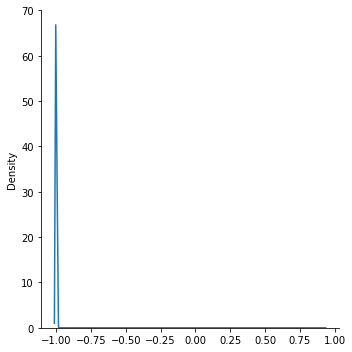

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 1.6481813881132337
Epoch 425: D (0.0000 real_err, 0.0227 fake_err) G (4.4667 err) 
Generated data: 
Min value: -1.0 / Max value: -0.23298867046833038
Note played simultaneously for generated data  mean/var: -83.99 / 0.00
Epoch 430: D (0.0000 real_err, 0.0478 fake_err) G (4.6129 err) 
Generated data: 
Min value: -1.0 / Max value: 0.9999997019767761
Note played simultaneously for generated data  mean/var: -83.93 / 0.01


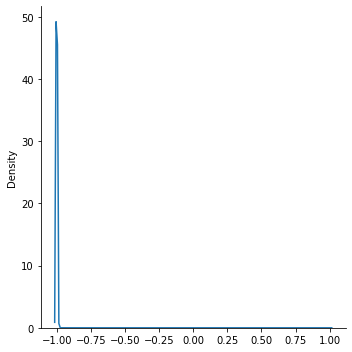

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 2.254279602898492
Epoch 435: D (0.0000 real_err, 0.0189 fake_err) G (4.6360 err) 
Generated data: 
Min value: -1.0 / Max value: -0.7973911762237549
Note played simultaneously for generated data  mean/var: -84.00 / 0.00
Epoch 440: D (0.7818 real_err, 0.0433 fake_err) G (1.6339 err) 
Generated data: 
Min value: -1.0 / Max value: -0.9863864183425903
Note played simultaneously for generated data  mean/var: -84.00 / 0.00


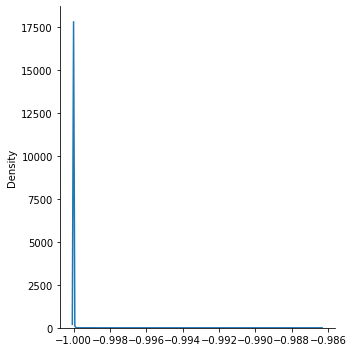

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 0.3360725614759657
Epoch 445: D (0.0000 real_err, 0.0179 fake_err) G (4.5437 err) 
Generated data: 
Min value: -1.0 / Max value: -0.989630401134491
Note played simultaneously for generated data  mean/var: -84.00 / 0.00
Epoch 450: D (0.0000 real_err, 0.0263 fake_err) G (4.6155 err) 
Generated data: 
Min value: -1.0 / Max value: -0.9957050085067749
Note played simultaneously for generated data  mean/var: -84.00 / 0.00


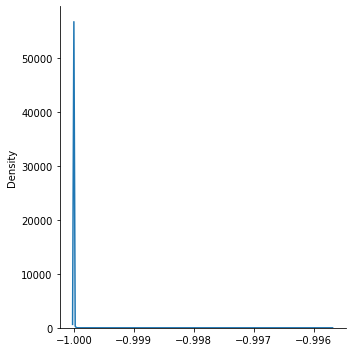

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 0.5644066916571723
Epoch 455: D (0.0000 real_err, 0.0388 fake_err) G (4.2644 err) 
Generated data: 
Min value: -1.0 / Max value: -0.5251321792602539
Note played simultaneously for generated data  mean/var: -84.00 / 0.00
Epoch 460: D (0.0000 real_err, 0.0212 fake_err) G (4.4909 err) 
Generated data: 
Min value: -1.0 / Max value: -0.9921743273735046
Note played simultaneously for generated data  mean/var: -84.00 / 0.00


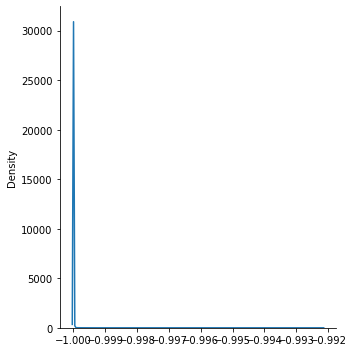

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 0.4939983526865641
Epoch 465: D (0.0000 real_err, 0.0385 fake_err) G (5.2632 err) 
Generated data: 
Min value: -1.0 / Max value: 0.7831131815910339
Note played simultaneously for generated data  mean/var: -83.98 / 0.00
Epoch 470: D (0.0000 real_err, 0.0199 fake_err) G (4.6425 err) 
Generated data: 
Min value: -1.0 / Max value: -0.9943375587463379
Note played simultaneously for generated data  mean/var: -84.00 / 0.00


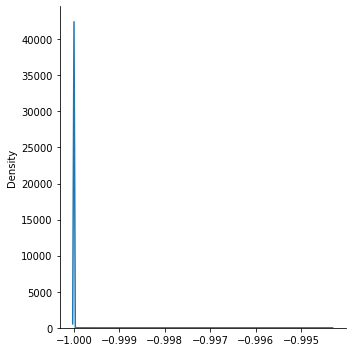

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 1.3474351856443616
Epoch 475: D (0.0000 real_err, 0.0194 fake_err) G (4.6907 err) 
Generated data: 
Min value: -1.0 / Max value: -0.9894050359725952
Note played simultaneously for generated data  mean/var: -84.00 / 0.00
Epoch 480: D (0.0000 real_err, 0.0222 fake_err) G (4.5325 err) 
Generated data: 
Min value: -1.0 / Max value: 0.1601250171661377
Note played simultaneously for generated data  mean/var: -83.99 / 0.00


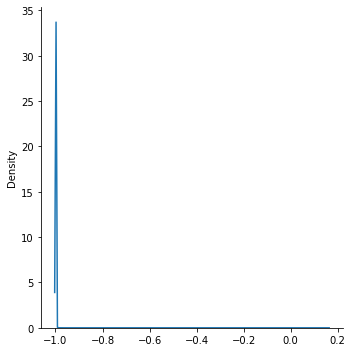

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 0.44739285310109456
Epoch 485: D (0.0000 real_err, 0.0197 fake_err) G (4.4474 err) 
Generated data: 
Min value: -1.0 / Max value: -0.9528172016143799
Note played simultaneously for generated data  mean/var: -84.00 / 0.00
Epoch 490: D (0.0000 real_err, 0.0252 fake_err) G (4.4406 err) 
Generated data: 
Min value: -1.0 / Max value: -0.9917150735855103
Note played simultaneously for generated data  mean/var: -84.00 / 0.00


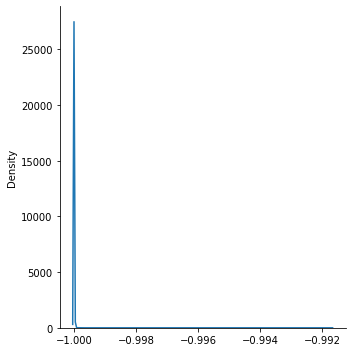

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Differences between generated data : 0.30576012664371066
Epoch 495: D (0.0000 real_err, 0.0246 fake_err) G (4.5475 err) 
Generated data: 
Min value: -1.0 / Max value: -0.9840052127838135
Note played simultaneously for generated data  mean/var: -84.00 / 0.00
Epoch 499: D (0.0000 real_err, 0.0243 fake_err) G (4.4741 err) 


In [ ]:
fake_data_list = []
landmark_seeds_data_list = []

nb_roll = 10

def extract(v):
    return v.data.storage().tolist()
epochs = []
d_fake_errs = []
d_real_errs = []
g_errs = []

# d_avg_notes = 0

for epoch in range(n_epochs):
    # for _ in range(20):  # train D for 20 steps
    for batch_idx, sample in enumerate(loader):

      ####### D_LOOP #########

    # 1. Train D on real+fake
      d_optimizer.zero_grad()  # could be d_optimizer.zero_grad() since the optimizer is specific to the model

      inputs, labels = sample
      N = len(inputs)
      # print(N)
      inputs_real_data, labels_real_data = inputs.to(device), labels.to(device)
      inputs_real_data = inputs_real_data.view((len(inputs),1, 64,84))

    #  1A: Train D on real
      d_real_decision = D(inputs_real_data)

      d_real_error = loss(
            d_real_decision, Variable(torch.ones([N, 1])).to(device)
        )  # ones = true
      d_real_error.backward()  # compute/store gradients, but don't change params

    #  1B: Train D on fake
      d_gen_seed = Variable(torch.FloatTensor(torch.randn(N, latent_dim))).to(
            device
        )
      d_gen_seed = d_gen_seed.view(N,latent_dim,1,1)
      d_fake_data = G(d_gen_seed).detach()  # detach to avoid training G on these labels
      d_fake_data = d_fake_data.view((len(inputs),1, 64,84))
      d_fake_decision = D(d_fake_data)
      d_fake_error = loss(
            d_fake_decision, Variable(torch.zeros([N, 1]).to(device))
        )  # zeros = fake


      dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0]
      d_fake_error.backward()
      d_optimizer.step()  # Only optimizes D's parameters; changes based on stored gradients from backward()

      ####### GET GEN INPUT ####
      G.zero_grad()

      g_gen_seed = Variable(torch.FloatTensor(torch.randn(N, latent_dim))).to(
                device
            )
      g_gen_seed = g_gen_seed.view(N,latent_dim,1,1)
      

      ###### D_ROLL LOOP #####

      backup = copy.deepcopy(D)
      for i in range(nb_roll):
        d_optimizer.zero_grad()
        ### Train D on Real ###
        
        d_real_decision = D(inputs_real_data)
        d_real_error = loss(
            d_real_decision, Variable(torch.ones([N, 1])).to(device)
        )  # ones = true
        # d_real_error.backward(create_graph=True)
        d_real_error.backward()

        ### Train D on Fake ###
        with torch.no_grad():
          d_fake_data = G(d_gen_seed).detach()  # detach to avoid training G on these labels
        d_fake_data = d_fake_data.view((len(inputs),1, 64,84))
        d_fake_decision = D(d_fake_data)
        d_fake_error = loss(
              d_fake_decision, Variable(torch.zeros([N, 1]).to(device))
          )  # zeros = fake
        d_fake_error.backward()
        d_optimizer.step()
      
      ##### TRAIN GEN ####
      
      g_fake_data = G(g_gen_seed)
      g_fake_data = g_fake_data.view(len(g_fake_data),1, 64,84)
      dg_fake_decision = D(g_fake_data)
      g_error = loss(
                dg_fake_decision, Variable(torch.ones([N, 1]).to(device))
            )  # Train G to pretend it's genuine

      g_error.backward()
      g_optimizer.step()

      ge = extract(g_error)[0]


      #### UNROLL D ####
      D.load(backup)
      del backup

      epochs.append(epoch)
      d_fake_errs.append(dfe)
      d_real_errs.append(dre)
      g_errs.append(ge)

    if epoch % 5 == 0:
      print(
            "Epoch %s: D (%1.4f real_err, %1.4f fake_err) G (%1.4f err) "
            % (epoch, dre, dfe, ge)
        )
      numpy_fake_data = g_fake_data.cpu().detach().numpy()
      nb_notes_per_data = np.zeros(len(numpy_fake_data))
      for i in range(len(numpy_fake_data)):
        nb_notes_per_data[i] = numpy_fake_data[i].sum()/64

      mean_notes = nb_notes_per_data.mean()
      var_notes = np.var(nb_notes_per_data)


      print("Generated data:", f"\nMin value: {numpy_fake_data.min()} / Max value: {numpy_fake_data.max()}")
      print(f"Note played simultaneously for generated data  mean/var: {mean_notes:.2f} / {var_notes:.2f}")
      
      if epoch % 10 == 0:
        sns.displot(numpy_fake_data.flatten(), kind="kde")
        plt.show()
        # print(numpy_fake_data)
        g_fake_data_landmarks = G(landmark_seeds.to(device))
        numpy_fake_data_landmarks = g_fake_data_landmarks.cpu().detach().numpy()
        fake_data_list.append((epoch, numpy_fake_data[0, :]))
        landmark_seeds_data_list.append((epoch, numpy_fake_data_landmarks))

        landmarks_differences = get_dist_matrix(numpy_fake_data_landmarks)
        print(f"Differences between generated data : {landmarks_differences}")

print(
    "Epoch %s: D (%1.4f real_err, %1.4f fake_err) G (%1.4f err) "
    % (epoch, dre, dfe, ge)
)




Text(0, 0.5, 'error')

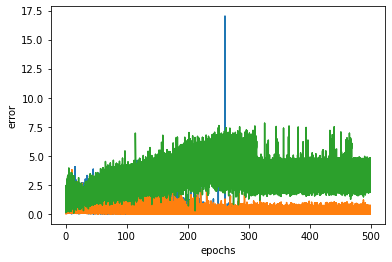

In [ ]:
plt.plot(epochs, d_fake_errs)
plt.plot(epochs, d_real_errs)
plt.plot(epochs, g_errs)
plt.xlabel("epochs")
plt.ylabel("error")

In [ ]:
def raw_to_midi(array, name, precision=0.5):
    pm = pretty_midi.PrettyMIDI()
    # Create an Instrument instance
    program = pretty_midi.instrument_name_to_program('Cello')
    piano = pretty_midi.Instrument(program=program)
    array = array.reshape((64, 84))
    
    for pitch_idx in range(84):
      for time_idx in range(64):
        if array[time_idx][pitch_idx] < -1 + precision:
          array[time_idx][pitch_idx] = -1
        elif array[time_idx][pitch_idx] > 1 - precision:
          array[time_idx][pitch_idx] = 1
        else:
          array[time_idx][pitch_idx] = 0


    for pitch_idx in range(84):
      for time_idx in range(64):
        if array[time_idx, pitch_idx] == 1:
          # Means we played a new note
          end_gap = 1
          if not time_idx == 63:
            while array[time_idx+end_gap, pitch_idx] == 0 and time_idx+end_gap < 63:
              end_gap += 1
          else:
            end_gap = 1
          note = pretty_midi.Note(
            velocity=100, pitch=25 + pitch_idx, start=1 / 8 * time_idx, end=(1 / 8) * (time_idx + end_gap))
          piano.notes.append(note)
    pm.instruments.append(piano)
    # Write out the MIDI data
    pm.write(f'midi_results/{name}.mid')

In [ ]:
import datetime
year, month, day = str(datetime.date.today()).split("-")
f_to_midi = [980, 600, 560, 500, 440, 460] 
indices = []
for idx in f_to_midi:
  indices.append([t[0] for t in fake_data_list].index(idx))

for i, idx in enumerate(indices):
  raw_to_midi(fake_data_list[idx][1], f"{month}_{day}_{f_to_midi[i]}", precision=0.5)

In [ ]:
raw_to_midi(fake_data_list[-5][1], "test", precision=0.5)